### Goal
Normalize data and prepare the input/targets for the modeling  pairs of tissues (X,Y) per invidividual. 

### TODO
1. Data
    - 1.1 Subset to protein coding genes
    - 1.2 Sparsity of the data
2. Normalize data
    - 2.1 Determine the major transcript for the gene:
        - most coding exons, if not then:
        - if two transcripts same #coding_exons:
            - choose transcript with less non-coding exons
            - if equal: choose lowest ENS number
        - if no coding exons, then choose most #exons:
            - if equal: choose lowest ENS number
    - 2.2 Parse raw_counts to FPKM
    - 2.3 Parse raw_counts to TPM
    - 2.4 Compare TPM from recount2 to GTEx data

### Conclusions
1. Data
    - Data sparsity for gtex data, only protein-coding gene expression: 33%
2. Normalize data
    - Major transcript per gene can be found under `/s/project/rep/processed/annotation/gene_annotation_gencode.v25_hg38.json`
    - Decided to use TPM instead FPKM, because TPMs measure the relative expression abundance per sample (the mapped fragments sum up to 1Mb)
    - recount2 data has similar profile as displayed on GTEx portal.

In [44]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import h5py
import anndata

from rep import preprocessing_new as p
from rep import plot as po

import plotly
import plotly.plotly as py
from plotly.graph_objs import graph_objs

# set credentials
plotly.tools.set_credentials_file(username='gium', api_key='nUFs5UnmuBR3pEbGIMj8')

import warnings; warnings.simplefilter('ignore')

### 1. Data


In [3]:
os.getcwd()

'/data/nasif12/home_if12/giurgiu/rep_gagneur/rep/notebooks/preprocessing'

#### 1.1 Filter summarized experiment by keeping only protein coding genes

In [3]:
# load gtex summarized experiment
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex.h5ad")
gtex = p.load(file)

# remove genes (x-axis) with no counts accross all samples (y-axis, tissues x invididuals)
zero_elem = np.where(~gtex.X.any(axis=0))[0]

# remove noncoding genes
protein_coding = []
with open(os.path.join(os.readlink(os.path.join("..","..","data")),"raw","annotation","gencode_v25_protein_coding_genes.txt")) as f:
    for line in f: protein_coding.append(line.replace("\n","").split(".")[0])

tokeep = [gene for i,gene in enumerate(gtex.genes_names) if i not in zero_elem and gene.split(".")[0] in protein_coding]

In [4]:
filtered_gtex = gtex[:,tokeep]

In [4]:
del gtex, zero_elem

In [27]:
repobj = p.RepAnnData(X=filtered_gtex.X,genes_var=filtered_gtex.var,samples_obs=filtered_gtex.obs)

In [29]:
repobj.save(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_filtered.h5ad"))

'/s/project/rep/processed/gtex/recount/recount_gtex_filtered.h5ad'

#### 1.2 Sparsity of the data

In [10]:
# percent of sparsity of Xs
size = filtered_gtex.X.shape[0]*filtered_gtex.X.shape[1]
(size - np.count_nonzero(np.array(filtered_gtex.X)))/(size)

0.3367858144856668

### 2. Normalize data

#### 2.1 Determine the major transcript for the gene

In [6]:
# extract annotation for all genes
path = os.path.join(os.readlink(os.path.join("..","..","data")),"raw","annotation")
file = os.path.join(path,"gencode.v25.basic.annotation.gtf")
gene_annotation = p.get_annotation(file)
p.writeJSON(gene_annotation, os.path.join(os.readlink(os.path.join("..","..","data")),"processed","annotation","gene_annotation_gencode.v25_hg38.json"))

In [7]:
# check if the annotation is consistent between recount2 and gencode.v25
annotation_recount = repobj.genes.index.tolist()
for a in annotation_recount:
    if a not in gene_annotation:
        print("Annotation not found: ", a)

#### 2.2 Raw counts to FPKMs

Normalize data to FPKMs. (Counts of mapped fragments * 1000 * 1000) / (Length of transcript (kb) * Total Count of mapped fragments)

- Counts of mapped fragments = number of fragments mapped per sample
- Length of transcripts = choose per gene the transcript with most exons and get the length of the exonic regions (in kb)
- Total Count of mapped fragments = total counts per sample

In [30]:
# raw counts to FPKM
# (Counts of mapped fragments * 1000 * 1000) / (Length of transcript * Total Count of mapped fragments)
x_norm = p.raw_counts2fpkm(repobj, gene_annotation)
norm_gtex = p.RepAnnData(X=x_norm,samples_obs=repobj.samples,genes_var=repobj.genes)
norm_gtex.save(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_norm_fpkm.h5ad"))

'/s/project/rep/processed/gtex/recount/recount_gtex_norm_fpkm.h5ad'

Plot correlation between raw matrix and normalized matrix

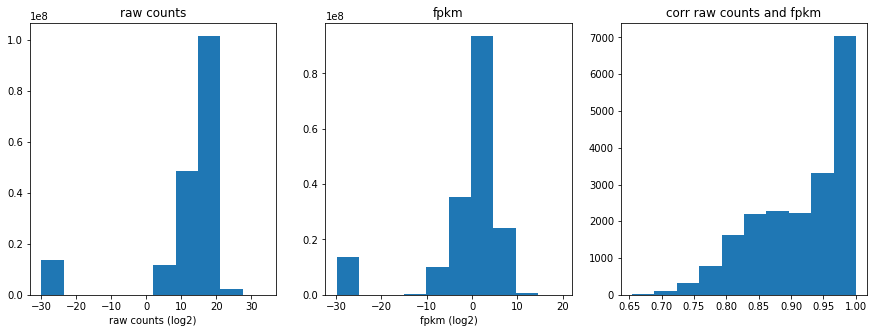

In [32]:
fig = plt.figure(figsize=(15,5))
ax1=fig.add_subplot(131)
plt.hist(np.log2(repobj.X.reshape(1,-1).squeeze() +  0.000000001))
plt.title("raw counts")
plt.xlabel("raw counts (log2)")
# ax1.set_xscale('log', basex=2)
# plt.xlim(0,1024)

ax2=fig.add_subplot(132)
plt.hist(np.log2(norm_gtex.X.reshape(1,-1).squeeze() + 0.000000001))
plt.title("fpkm")
plt.xlabel("fpkm (log2)")
# ax2.set_xscale('log', basex=2)
# plt.xlim(0,1024)

fig.add_subplot(133)
corr_values = pd.Series([stats.spearmanr(repobj.X[:, i], norm_gtex.X[:, i])[0]  for i in range(repobj.X.shape[1])])
plt.hist(corr_values.dropna())
plt.title("corr raw counts and fpkm")

plt.show()

#### 2.3. Raw counts to TPMs

Let N_i be the number of reads coming from gene i and L_i be the length of gene i. 
TPM_i = 10^6 * (N_i / L_i) / [Σ_j (N_j / L_j)]

In [35]:
x_norm_tpm = p.raw_counts2tpm(repobj, gene_annotation)
norm_gtex_tpm = p.RepAnnData(X=x_norm_tpm,samples_obs=repobj.samples,genes_var=repobj.genes)
norm_gtex_tpm.save(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_norm_tmp.h5ad"))

'/s/project/rep/processed/gtex/recount/recount_gtex_norm_tmp.h5ad'

Text(0.5, 0, 'tpm')

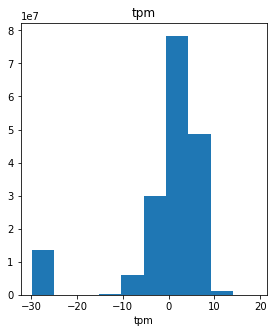

In [36]:
fig = plt.figure(figsize=(15,5))
ax1=fig.add_subplot(131)
plt.hist(np.log2(norm_gtex_tpm.X.reshape(1,-1).squeeze() +  0.000000001))
plt.title("tpm")
plt.xlabel("tpm")

Compare the parsed data with GTEx data online for several genes

#### 2.4 Compare TPM from recount2 to GTEx data

We compare the TPM of gene = 'ENSG00000000003.14' between the GTEx Portal results and the recount2 data (after the in-house preprocessing step). This ensures that the data what we use and the computation of TPM are correct.

In [37]:
# rander svg img into jupyter-lab notebook
from IPython.display import SVG, display, Image
def show_img(path):
    extension = path.split(".")
    extension = extension[-1]
    if extension == 'svg': display(SVG(filename=path))
    else: 
        img = Image(path)
        display(img)

In [38]:
# list of tissues and parent tissues
tissues = sorted(list(set(norm_gtex_tpm.samples['Tissue'].tolist())))
parent_tissue = sorted(list(set(norm_gtex_tpm.samples['Parent_Tissue'].tolist())))

# generate colors
palette = sns.color_palette(None, len(parent_tissue)).as_hex()

In [42]:
# generate data
data = []

# PTEN "ENSG00000171862.9"
# TSPAN6 "ENSG00000000003.14"
# OPALIN - brain enriched ENSG00000197430.10
# TTN - muscles enriched ENSG00000155657.25 - hier they cut at 1200 (removed an outlier with TPM=8000 ish)
gene = 'ENSG00000000003.14'
gtex_tmp = norm_gtex_tpm[:,gene] # after filtering this is converted to AnnData
for t in tissues:
    pt = list(set(gtex_tmp[gtex_tmp.obs['Tissue'] == t].obs['Parent_Tissue'].tolist()))[0]
    color_pt = palette[parent_tissue.index(pt)]
    data.append(graph_objs.Box(y=gtex_tmp[norm_gtex_tpm.obs['Tissue'] == t].X, 
                                name=t,
                                fillcolor= color_pt,
                                marker = dict(
                                    color = color_pt)))

In [47]:
# plot figure
fig = graph_objs.Figure(data=data, layout=po.get_layout(_xlab='Tissues',_ylab='TPM',_title= "recount2 - Expression of " + gene))
py.iplot(fig, filename='tpm_per_tissue_' + gene)

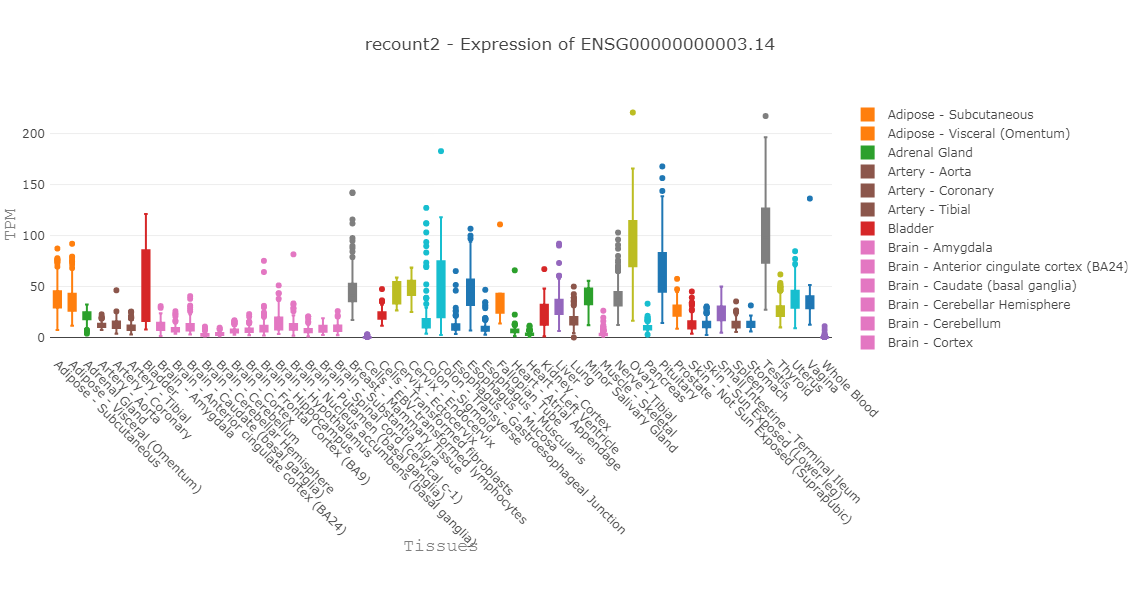

In [21]:
show_img('2_normalize_gtex_files/tpm_ENSG00000000003.png')

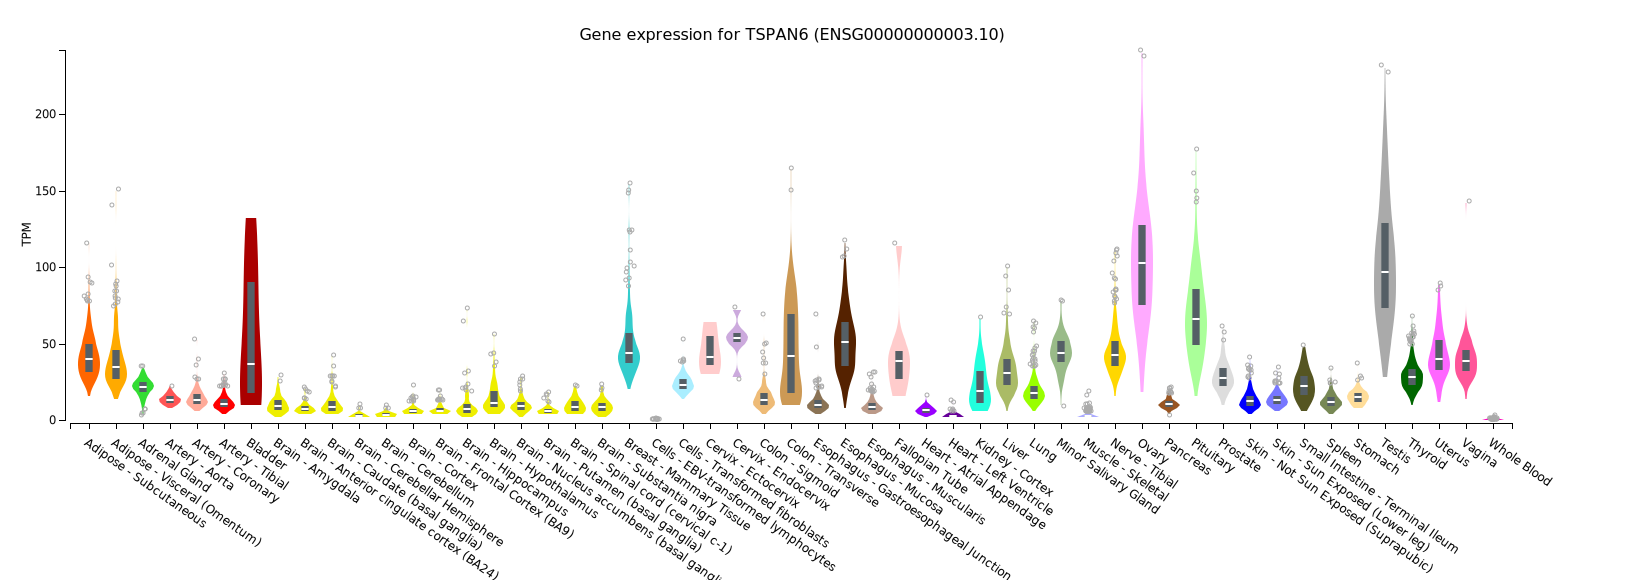

In [48]:
show_img('2_normalize_gtex_files/2_normalize_gtex_25_0.svg')